# SPICY Tutorial 3

In this tutorial, we implement a constrained regression of a 2D velocity field, and we combine the lessons learned in the previous two tutorials to compute pressure fields.

In [55]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io
from spicy_class_m import spicy

# This is for plot customization
fontsize = 12
plt.rc('text', usetex=True)      
plt.rc('font', family='serif')
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['font.size'] = fontsize

This test case is the 2D flow past a cylinder, a typical benchmark test case. The data is taken from https://github.com/Raocp/PINN-laminar-flow. The geometry has a height of $0.41\,$m, a length of $1.1\,$m, and the cylinder a radius of $0.02\,$m placed slightly off the middle of the channel. The solution is provided in the form of a .mat file which is read with Scipy.

To prepare the dataset, we remove the points at the inlet and the wall, as these will be introduced as constraints. We then extract the remaining 18755 points for the regression. As for the Oseen vortex, we add some noise to the velocity data.

In [56]:
# Fix random seed to ensure reproducibility
np.random.seed(42)

# Properties of the domain and flow
R = 0.05 # m
H = 0.41 # m
L = 1.1 # m
mu = 2e-2 # Pa s
rho = 1 # kg/m^3

# Load the matlab data from the ansys solution
data = scipy.io.loadmat('FluentSol.mat')
# Extract the x, y values
X = data['x'].reshape(-1); Y = data['y'].reshape(-1) 
# Extract the velocities and pressure
U = data['vx'].reshape(-1); V = data['vy'].reshape(-1); P = data['p'].reshape(-1)

# Here, we remove the points at the inlet and at the wall, as they are given by the constraints
inlet_and_wall_remover = np.invert(np.logical_or(np.logical_and(U==0, V==0), X==0))
# Remove the points
X_p = X[inlet_and_wall_remover]; Y_p = Y[inlet_and_wall_remover]; P_p = P[inlet_and_wall_remover]
U_p = U[inlet_and_wall_remover]; V_p = V[inlet_and_wall_remover]


From the remaining points we can choose to sample a random amount of points if we want to go for a smaller test case. In this
tutorial, we take a maximum of 18755 points. We will use 80% of these and keep 20% to evaluate the RBF prediction performances in out of sample conditions


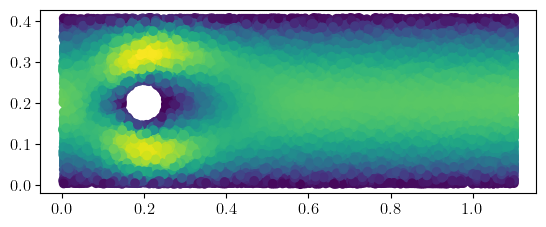

In [57]:
# A testing data, we take the ones that are not in this list.
from sklearn.model_selection import train_test_split
indices_train, indices_test=train_test_split(np.arange(0,len(X_p),1),test_size=0.2)

n_p = len(indices_train) # This is the number of data points that will be used for training

# Select the data points that will be used for  training 
X = X_p[indices_train]; Y = Y_p[indices_train]; P = P_p[indices_train]
U = U_p[indices_train]; V = V_p[indices_train]

# Add 0.3 noise to the velocity field
q = 0.05
U_noise = U * (1 + q * np.random.uniform(-1, 1, size = U.shape))
V_noise = V * (1 + q * np.random.uniform(-1, 1, size = V.shape))

# Let's have a look at the velocity data:
fig=plt.figure(11)
plt.scatter(X,Y,c=np.sqrt(U**2+V**2))
plt.gca().set_aspect(1)

### Step 1: Define the boundary conditions/constraints
We define the BC's below. 50 constraints in each of the five domain boundaries: inlet+ outlet, upper+ lower wall and cylinder wall. We put Dirichlet boundary conditions on all boundaries except the outlet and divergence-free conditions on all of them.

At the inlet, we impose the parabolic velocity profile from the CFD data. In all walls we set zero velocity.

In [58]:
## Boundary and Constraint Definitions
n_c = 50

# Left boundary (index: 1)
X_Div1 = np.zeros(n_c)
Y_Div1 = np.linspace(0, H, n_c)
U_Dir1 = 4*(H-Y_Div1)*Y_Div1/H**2
V_Dir1 = np.zeros(X_Div1.shape)
# Bottom boundary (index: 2)
X_Div2 = np.linspace(0, L, n_c)
Y_Div2 = np.zeros(n_c)
U_Dir2 = np.zeros(X_Div2.shape)
V_Dir2 = np.zeros(X_Div2.shape)
# Right boundary (index: 3)
X_Div3 = np.ones(n_c-2)*L
Y_Div3 = np.linspace(0, H, n_c)[1:-1]
# Top boundary (index: 4)
X_Div4 = np.linspace(0, L, n_c)
Y_Div4 = np.ones(n_c)*H
U_Dir4 = np.zeros(X_Div4.shape)
V_Dir4 = np.zeros(X_Div4.shape)
# Cylinder boundary (index: 4)
alphaT = np.linspace(0, 2*np.pi, 20*n_c, endpoint = False)
X_Div5 = 0.2+R*np.cos(alphaT)
Y_Div5 = 0.2+R*np.sin(alphaT)
U_Dir5 = np.zeros(X_Div5.shape)
V_Dir5 = np.zeros(X_Div5.shape)

# We assemble the velocity constraints for Dirichlet
X_Dir = np.concatenate((X_Div1, X_Div2, X_Div4, X_Div5))
Y_Dir = np.concatenate((Y_Div1, Y_Div2, Y_Div4, Y_Div5))
U_Dir = np.concatenate((U_Dir1, U_Dir2, U_Dir4, U_Dir5))
V_Dir = np.concatenate((V_Dir1, V_Dir2, V_Dir4, V_Dir5))
# and Divergence-free flow
X_Div = np.concatenate((X_Div1, X_Div2, X_Div3, X_Div4, X_Div5))
Y_Div = np.concatenate((Y_Div1, Y_Div2, Y_Div3, Y_Div4, Y_Div5))

# We remove the duplicates in the Dirchlet 
_, valid_idcs = np.unique(np.column_stack((X_Div, Y_Div)), return_index = True, axis = 0)
X_Div = X_Div[valid_idcs]
Y_Div = Y_Div[valid_idcs]
DIV = [X_Div, Y_Div]

# and Divergence-free conditions
_, valid_idcs = np.unique(np.column_stack((X_Dir, Y_Dir)), return_index = True, axis = 0)
X_Dir = X_Dir[valid_idcs]
Y_Dir = Y_Dir[valid_idcs]
U_Dir = U_Dir[valid_idcs]
V_Dir = V_Dir[valid_idcs]
DIR = [X_Dir, Y_Dir, U_Dir, V_Dir]


### Step 2: Clustering with Different Regions

In the same way local mesh refinements are often used in CFD, SPICY allows for defining regions of difference collocation density. We can expect velocity gradients to be much larger near the cylinder, somewhere up to x=0.4 (see the previous plot).

We will thus define two boxes: one near the cylinder that will have the largest collocation density, another slightly larger having an intermediate density of collocation points. Then, we will also include very large Gaussians in the rest of the domain. First, let's create the boxes using shapely



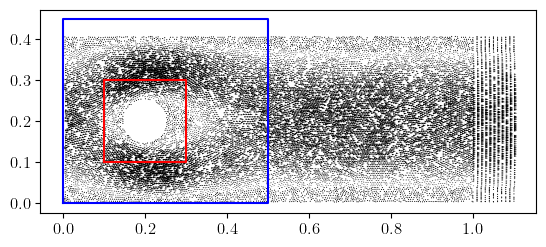

In [59]:
from shapely import geometry

# Definition of Box 1
p1 = geometry.Point(0.1,0.1); p2 = geometry.Point(0.3,0.1)
p3 = geometry.Point(0.3,0.3); p4 = geometry.Point(0.1,0.3)

pointList = [p1, p2, p3, p4]
poly1 = geometry.Polygon([i for i in pointList])  # BOX one

# Definition of Box 2 

# Define also a second box
p1 = geometry.Point(0.0,0); p2 = geometry.Point(0.5,0)
p3 = geometry.Point(0.5,0.45); p4 = geometry.Point(0.0,0.45)

pointList = [p1, p2, p3, p4]
poly2 = geometry.Polygon([i for i in pointList])

# Plot the boxes with the velocity field
fig=plt.figure()
plt.quiver(X,Y,U,V)
plt.gca().set_aspect(1)
plt.plot(*poly2.exterior.xy,'b') # in case you want to see them for info
plt.plot(*poly1.exterior.xy,'r') # in case you want to see them for info


Note that it is not necessary to have the boxes within the domain. The clustering will involve at each level the points (particles) available within each box. We now proceed creating the SPICY object and providing the Areas as shapely polygons.

We will use four levels, with n_k=[3,6,50,200], with the areas Areas=[poly1,poly2,[],[]]. This means that the last two clustering levels will act on the entire domain.

Then we plot the results at each level.  


Clustering level 0 completed
Clustering level 1 completed
Clustering level 2 completed
Clustering level 3 completed
1797 RBFs placed
1148 D conditions assigned
0 N conditions assigned
1196 Div conditions assigned


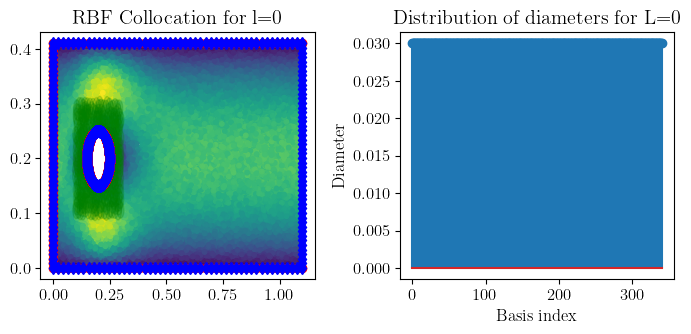

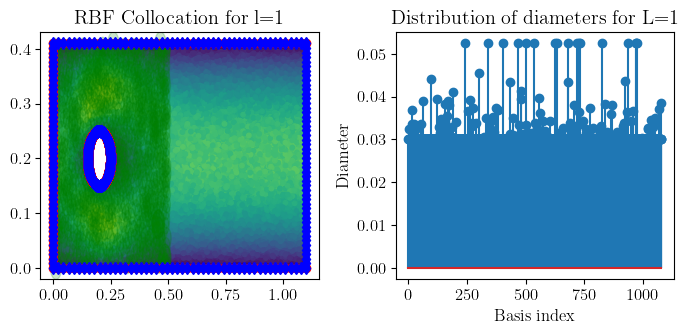

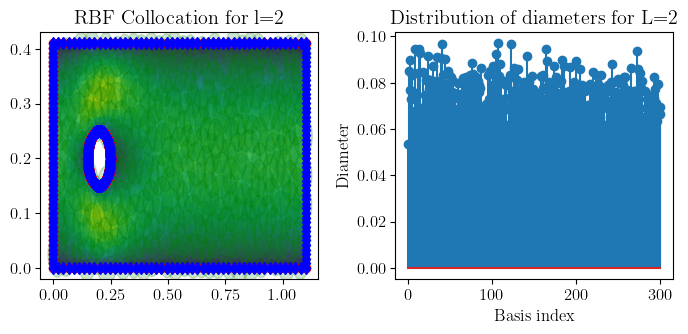

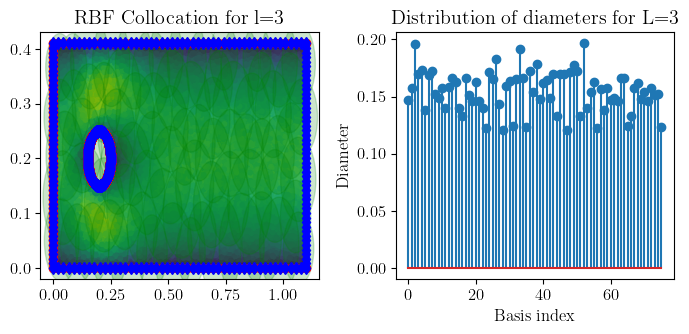

In [60]:
# Prepare the SPICY object
SP_vel = spicy([U_noise,V_noise], [X,Y], basis='gauss')
# Clustering 
SP_vel.clustering([3,6,50,200], Areas=[poly1,poly2,[],[]], r_mM=[0.015,0.3], eps_l=0.87)
# Introduce the Constraints
SP_vel.vector_constraints(DIR=DIR, DIV=DIV, extra_RBF=True)
# Plot the RBF cluster
SP_vel.plot_RBFs(l=0)
SP_vel.plot_RBFs(l=1)
SP_vel.plot_RBFs(l=2)
SP_vel.plot_RBFs(l=3)

Note that the cluster closer to the cylinder, with the highest density, hits the lower boundary of allowed RBF radiuses: as a result, SPICY sets all RBFs at the smallest radius allowed. Use the zooming functionality on Spyder to explore the clustering levels.

### Step 2: RBF Training and testing

We proceed with the assembly of the linear system and the 'training' of the RBF. Note: we will allow a fairly large K_cond!

In [61]:
# Assembly the system
SP_vel.Assembly_Regression(alpha_div=1) 
# Solve the system
SP_vel.Solve(K_cond=1e12)


Solving with constraints
Matrix A regularized
Chol factor of M WITH regularization
Lambdas computed
w computed


Now we evaluate the accuracy of the analytic model on both the testing data and the training data (those points we removed at the beginning!).

In [62]:
# Get the solution
U_calc,V_calc=SP_vel.Get_Sol([X,Y])

# Magnitude of the RBF solution
U_magn_calc = np.sqrt(U_calc**2 + V_calc**2)
# Compute the magnitude of the analytical solution
U_magn = np.sqrt(U**2 + V**2)
# Compute the error in the magnitude
error_magn = np.linalg.norm(U_magn_calc - U_magn) / np.linalg.norm(U_magn)
# Error in u
error_u = np.linalg.norm(U_calc - U) / np.linalg.norm(U)
# Error in v
error_v = np.linalg.norm(V_calc - V) / np.linalg.norm(V)

print('------- In-sample error results ---------')
print('Total velocity error: {0:.3f}%'.format(error_magn*100))
print('Velocity error in u:  {0:.3f}%'.format(error_u*100))
print('Velocity error in v:  {0:.3f}%'.format(error_v*100))

# we now check the out-of sample results.
# Get out of sample position
U_out=U_p[indices_test];  V_out=V_p[indices_test]
X_out=X_p[indices_test];  Y_out=Y_p[indices_test]

# Out of sample predictions
U_calc_O,V_calc_O=SP_vel.Get_Sol([X_out,Y_out])

# Magnitude of the RBF solution
U_magn_calc_O = np.sqrt(U_calc_O**2 + V_calc_O**2)
# Compute the magnitude of the analytical solution
U_magn_O = np.sqrt(U_out**2 + V_out**2)
# Compute the error in the magnitude
error_magn_O = np.linalg.norm(U_magn_calc_O - U_magn_O)/np.linalg.norm(U_magn_O)
# Error in u
error_u_O = np.linalg.norm(U_calc_O - U_out) / np.linalg.norm(U_out)
# Error in v
error_v_O = np.linalg.norm(V_calc_O - V_out) / np.linalg.norm(V_out)


print('------- Out of sample error results ---------')
print('Total velocity error: {0:.3f}%'.format(error_magn_O*100))
print('Velocity error in u:  {0:.3f}%'.format(error_u_O*100))
print('Velocity error in v:  {0:.3f}%'.format(error_v_O*100))


------- In-sample error results ---------
Total velocity error: 0.483%
Velocity error in u:  0.472%
Velocity error in v:  1.961%
------- Out of sample error results ---------
Total velocity error: 0.516%
Velocity error in u:  0.498%
Velocity error in v:  2.104%


Note that both the in-sample and the out-of-sample errors are quite low! We plot the results together with the data to see the difference... can you see it :) ?

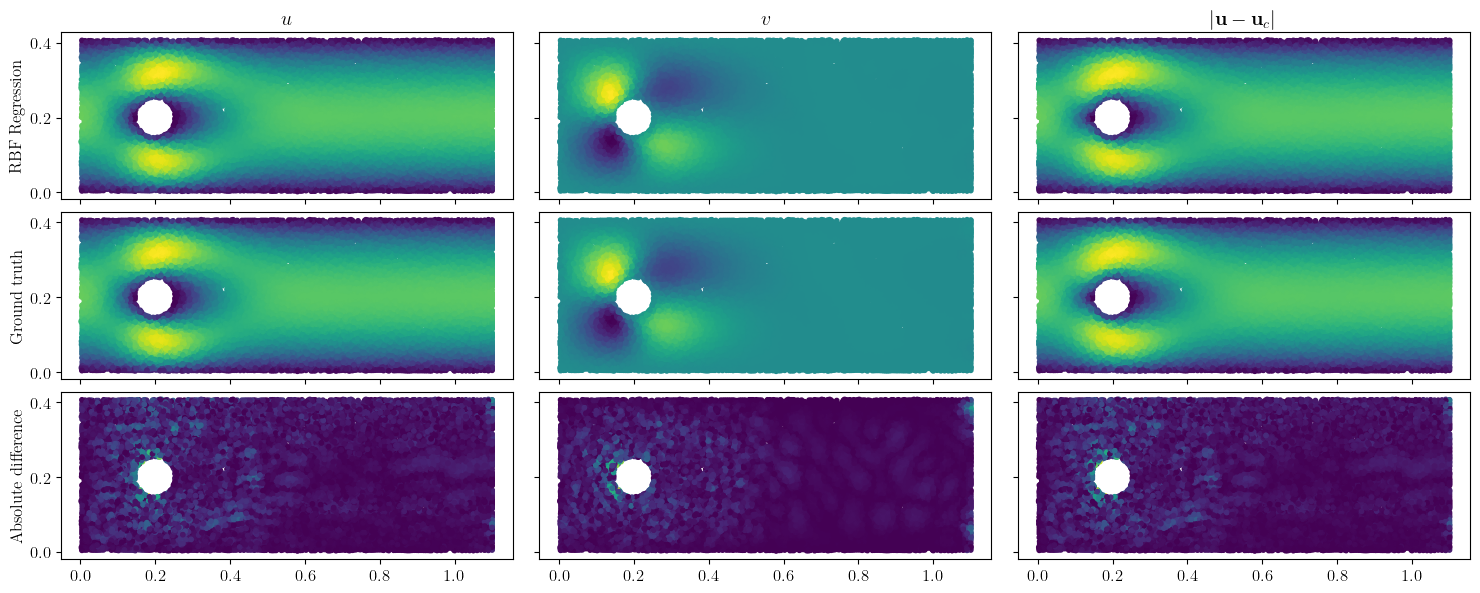

In [63]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(15,6), dpi=100, sharex=True, sharey=True)
axes[0,0].scatter(X, Y, c=U_calc, s=10)
axes[1,0].scatter(X, Y, c=U, s=10)
axes[2,0].scatter(X, Y, c=np.abs(U_calc-U), s=10) 

axes[0,1].scatter(X, Y, c=V_calc, s=10)
axes[1,1].scatter(X, Y, c=V, s=10)
axes[2,1].scatter(X, Y, c=np.abs(V_calc-V), s=10)  

axes[0,2].scatter(X, Y, c=U_magn_calc, s=10)
axes[1,2].scatter(X, Y, c=U_magn, s=10)
axes[2,2].scatter(X, Y, c=np.abs(U_magn_calc-U_magn), s=10) 


axes[0,0].set_ylabel('RBF Regression') 
axes[1,0].set_ylabel('Ground truth')  
axes[2,0].set_ylabel('Absolute difference')  

axes[0,0].set_title('$u$') 
axes[0,1].set_title('$v$')  
axes[0,2].set_title('$|\mathbf{u}-\mathbf{u}_c|$')      
for ax in axes.flatten():
    ax.set_aspect(1)      
fig.tight_layout()      



### Step 3: Pressure computation

As we now have an analytic expression for the velocity field, we proceed with the pressure integration. We start by defining the boundary conditions/constraints. Here's the list:

1. On all patches, we introduce Neumann conditions (these will be computed directly from the velocity field). To impose these we will need to prepare the vector of normals over each of them. These conditions do not require extra measurements.

2. On the outlet patch, we introduce Dirichlet boundary conditions. Sufficiently far from the cylinder wake, it is reasonable to assume that the pressure has recovered its free stream condition, which in our case is 0 since the CFD that generated the data works with the gauge pressure.

3. We will impose a Dirichlet condition somewhere in the domain (and you are asked to move it around!) This simulates having a static pressure probe somewhere in our wind tunnel.

let's get to work:

In [66]:
# Number of constraints on each boundary
n_c = 100

################################# Define the Location for the Neumann conditions (5 patches) #################
# We start with the Neumann conditions
# Left boundary
X_Pres_N1 = np.zeros(n_c)
Y_Pres_N1 = np.linspace(0, H, n_c)
# Bottom boundary
X_Pres_N2 = np.linspace(0.0,L,n_c)
Y_Pres_N2 = np.zeros(n_c)
# Top boundary
X_Pres_N4 = np.linspace(0, L, n_c)
Y_Pres_N4 = np.ones(n_c)*H
# Cylinder boundary
alpha_P = np.linspace(0, 2*np.pi, n_c, endpoint = False) 
X_Pres_N5 = 0.2 + R*np.cos(alpha_P)
Y_Pres_N5 = 0.2 + R*np.sin(alpha_P)
# Assemble the the entire array of Neumann points
X_Pres_N=np.hstack((X_Pres_N1, X_Pres_N2, X_Pres_N4, X_Pres_N5))
Y_Pres_N=np.hstack((Y_Pres_N1, Y_Pres_N2, Y_Pres_N4, Y_Pres_N5))

############################### Compute the normal vectors for all patches requireing N conditions #################

# We assemble the normals in the same way
# Left boundary
n_x_1 = np.ones(X_Pres_N1.shape)*(-1)
n_y_1 = np.ones(X_Pres_N1.shape)*0
# Bottom boundary
n_x_2 = np.ones(X_Pres_N2.shape)*0
n_y_2 = np.ones(X_Pres_N2.shape)*(-1)
# Top boundary
n_x_4 = np.ones(X_Pres_N4.shape)*0
n_y_4 = np.ones(X_Pres_N4.shape)*1
# Cylinder boundary
n_x_5 = np.ones(X_Pres_N5.shape)*(-np.cos(alpha_P))
n_y_5 = np.ones(X_Pres_N5.shape)*(-np.sin(alpha_P))
# Assemble to obtain the entire array of Neumann normals
n_x = np.hstack((n_x_1, n_x_2, n_x_4, n_x_5))
n_y = np.hstack((n_y_1, n_y_2, n_y_4, n_y_5))  


############### Clean for possible repeaded points (usually along corners ) ############################################
_, valid_idcs = np.unique(np.column_stack((X_Pres_N, Y_Pres_N)),
                          return_index = True, axis = 0)
X_Pres_N = X_Pres_N[valid_idcs]
Y_Pres_N = Y_Pres_N[valid_idcs]
n_x = n_x[valid_idcs]
n_y = n_y[valid_idcs]

######################### Define location (and value) for the Dirichlet (D) condition at the outlet ###################

X_Pres_D3 = np.ones(n_c-2)*L
Y_Pres_D3 = np.linspace(0, H, n_c)[1:-1]

#################### Define the location of the pressure probe from which we will take another D condition #################

x_loc=0.4; y_loc=0.2    ### PLAY WITH THIS !! # this is the approximate location of the pressure prob.

# look for the close point
x_err=(X_p-x_loc)**2+(Y_p-y_loc)**2
index_probe=np.argmin(x_err)

# Define the Dirichlet condition associated to the probe.
X_S=X_p[index_probe]
Y_S=Y_p[index_probe]
P_S=P_p[index_probe]

# thus the full set of D conditions is :
X_Pres_D = np.append(X_Pres_D3,X_S)
Y_Pres_D = np.append(Y_Pres_D3,Y_S)
P_Pres_D = np.hstack([np.zeros(X_Pres_D3.shape),P_S])


We now assembly the Poisson problem. First compute the source term from the velocity field and the N conditions. We perform a slightly differnt clusterng than before (allowing for larger Gaussians) but we keep the same area partitioning.

Clustering level 0 completed
Clustering level 1 completed
Clustering level 2 completed
Clustering level 3 completed
Clustering level 4 completed
1382 RBFs placed
99 Dirichlet conditions assigned
398 Neumann conditions assigned


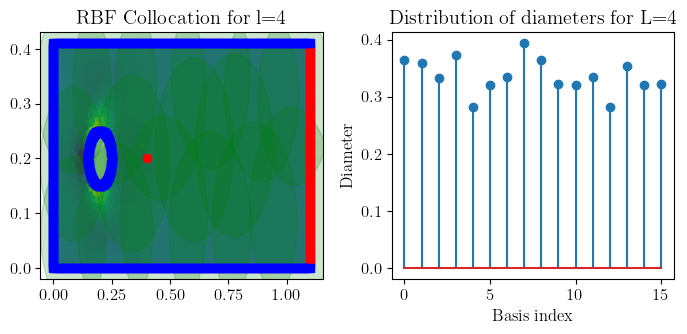

In [70]:
# First we compute the required quantities from the velocity field 
# (neither of the following 2 steps runs if SP_Vel has not been solved)
# 1. Evaluate the source term on the RHS of the Poisson equation
source_term = SP_vel.Evaluate_Source_Term(grid=[X,Y], rho=rho)
# 2. Evaluate the c_N for the N conditions (see Presentation 1)
P_Neu = SP_vel.Get_Pressure_Neumann(grid = [X_Pres_N, Y_Pres_N], 
                                    normals = [n_x, n_y],
                                    rho = rho, mu = mu)

# We can now proceed with (1) spicy initialization (2) clustering (3) constraint assingment, (4) System Assembly:

# We assemble our Neumann and Dirichlet B.C.
NEU_P = [X_Pres_N, Y_Pres_N, n_x, n_y, P_Neu]
DIR_P = [X_Pres_D, Y_Pres_D, P_Pres_D]

SP_pres = spicy([source_term], [X,Y], basis='gauss')
SP_pres.clustering([3,10,50,200,1000], Areas=[poly1,poly2,[],[],[]], r_mM=[0.015,0.5], eps_l=0.87)

# And, we set them
SP_pres.scalar_constraints(DIR=DIR_P, 
                           NEU=NEU_P, 
                           extra_RBF=True)

SP_pres.plot_RBFs(l=4) # Plot the clustering a level 

SP_pres.Assembly_Poisson() # Assembly the system


 We solve the system compare the results on the training and testing locations! 

Solving with constraints
Matrix A regularized
Chol factor of M WITH regularization
Lambdas computed
w computed
------- in sample pressure error results ---------
Total pressure error: 2.377%
------- out of sample pressure error results ---------
Total pressure error: 2.402%


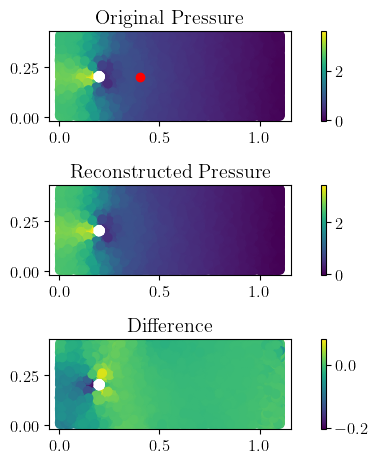

In [71]:
SP_pres.Solve(K_cond=1e9) # Solve the system

# Check the results on the 'training data'
P_calc = SP_pres.Get_Sol(grid=[X,Y])
# print the pressure error
error_p = np.linalg.norm(P_calc-P)/np.linalg.norm(P)
print('------- in sample pressure error results ---------')
print('Total pressure error: {0:.3f}%'.format(error_p*100))

# Check the results on the 'testing data'
P_calc_test = SP_pres.Get_Sol(grid=[X_p[indices_test],Y_p[indices_test]])
P_test=P_p[indices_test]
error_p = np.linalg.norm(P_calc_test-P_test)/np.linalg.norm(P_test)
print('------- out of sample pressure error results ---------')
print('Total pressure error: {0:.3f}%'.format(error_p*100))



fig, axes = plt.subplots(nrows=3, dpi=100)
axes[0].set_title('Original Pressure')
sc=axes[0].scatter(X, Y, c=P)
plt.colorbar(sc,ax=axes[0])
axes[0].plot(X_S,Y_S,'ro')
axes[1].set_title('Reconstructed Pressure')
sc2=axes[1].scatter(X, Y, c=P_calc)
plt.colorbar(sc2,ax=axes[1])
axes[2].set_title('Difference')
sc3=axes[2].scatter(X, Y, c=P_calc-P)
plt.colorbar(sc3,ax=axes[2])


for ax in axes.flatten():
    ax.set_aspect(1)
fig.tight_layout()



BOth in sample and out of sample error are encouraging. Now try to change the position of the pressure prob (or even remove it) and you will see how important it is: getting pressure from image velocimetry is a difficult task and without the help of some Dirichlet conditions you can't do miracles.